In [48]:
import os
import numpy as np
from PIL import Image
import random

def temporal_reverse(snippet):
    """Reverse the order of frames in the snippet."""
    return snippet[::-1]

def jittered_rotation(snippet):
    """Apply jittered rotations (0°, 90°, 180°, 270°) plus random noise [-3°, 3°]."""
    rotated_snippet = []
    rotation_classes = []  # Keep track of the base rotation class for labeling
    for frame in snippet:
        base_angle = random.choice([0, 90, 180, 270])
        noise = random.uniform(-3, 3)  # Random noise in [-3°, 3°]
        total_rotation = base_angle + noise
        # Convert the base angle to class for labeling
        if base_angle == 0:
            rotation_class = 0
        elif base_angle == 90:
            rotation_class = 1
        elif base_angle == 180:
            rotation_class = 2
        elif base_angle == 270:
            rotation_class = 3
        # Assuming frame is a numpy array, apply the rotation
        rotated_frame = np.rot90(frame, k=total_rotation // 90)  # Quick rotation by 90° multiples
        rotated_snippet.append(rotated_frame)
        rotation_classes.append(rotation_class)
    
    # Use the most frequent rotation class in the snippet for labeling
    dominant_class = max(set(rotation_classes), key=rotation_classes.count)
    return rotated_snippet, dominant_class

def shuffle_snippet(snippet):
    """Randomly shuffle the order of frames in the snippet."""
    shuffled_snippet = snippet.copy()
    random.shuffle(shuffled_snippet)
    return shuffled_snippet

def vary_speed(snippet, speed_factor=2):
    """Adjust the speed of the snippet by changing the sampling rate."""
    if speed_factor > 1:
        adjusted_snippet = snippet[::int(speed_factor)]  # Fast-forward
    elif speed_factor < 1:
        adjusted_snippet = []
        repeat_factor = int(1 / speed_factor)  # Slow-motion
        for frame in snippet:
            adjusted_snippet.extend([frame] * repeat_factor)
    else:
        adjusted_snippet = snippet  # No change for speed_factor == 1
    return adjusted_snippet

def convert_to_three_channels(frame):
    """Convert a 2D grayscale frame to 3 channels (RGB)."""
    return np.stack([frame] * 3, axis=-1)

def save_groundtruth(groundtruth, gt_file, snippet_idx,types):
    """Save ground truth to a text file (one-hot encoded)."""
    gt_filename = os.path.join(gt_file, types, f"groundtruth_{types}_{snippet_idx}.txt")
    np.savetxt(gt_filename, groundtruth, fmt='%d')

def data_generator(data_path, snippet_length=10,gt_file=None, transformations=None):
    """Generator that yields augmented video snippets on-the-fly."""
    video_dirs = sorted(os.listdir(data_path))
    
    # Initialize lists to hold all transformations
    all_originals = []
    all_temporal_reverses = []
    all_shuffles = []
    all_jittered_rotations = []
    all_speed_variations = []
    snippet_idx = 0
    for video_dir in video_dirs:
        video_path = os.path.join(data_path, video_dir)
        
        # Read frames assuming they are TIFF images
        frames = []
        for f in sorted(os.listdir(video_path)):
            if f.endswith('.tif'):
                # Open the TIFF image and convert to 3-channel format
                frame = np.array(Image.open(os.path.join(video_path, f)))
                frame_3channel = convert_to_three_channels(frame)  # Convert to 3 channels
                frames.append(frame_3channel)
        
        # Divide the video into snippets
        for start in range(0, len(frames) - snippet_length + 1, snippet_length):
            snippet = frames[start:start + snippet_length]
            # Apply transformations
            original = snippet
            temporal_reverse_snippet = temporal_reverse(snippet)
            shuffled_snippet = shuffle_snippet(snippet)
            speed_variation_snippet = vary_speed(snippet, speed_factor=random.choice([0.5, 2]))  # Random speed variation
            jittered_rotation_snippet, dominant_class = jittered_rotation(snippet)
            groundtruth_jittered = np.zeros(4, dtype=int)
            groundtruth_jittered[dominant_class] = 1
            groundtruth_original = np.array([0, 1])  # Class 1: [0,1] for original
            groundtruth_augmented = np.array([1,0])  # Class 0: [1,0] for augmentation
            # save_groundtruth(groundtruth_original, gt_file, snippet_idx,'original')  # For original order
            # save_groundtruth(groundtruth_jittered, gt_file, snippet_idx,'rotation')
            # save_groundtruth(groundtruth_augmented, gt_file, snippet_idx,'augmented')  # For speed-adjusted order
            # Append to the lists
            all_originals.append(original)
            all_temporal_reverses.append(temporal_reverse_snippet)
            all_shuffles.append(shuffled_snippet)
            all_jittered_rotations.append(jittered_rotation_snippet)
            all_speed_variations.append(speed_variation_snippet)
            snippet_idx += 1
    # Yield the entire lists of transformations
    return {
        "original": all_originals,
        "reverse": all_temporal_reverses,
        "shuffle": all_shuffles,
        "rotation": all_jittered_rotations,
        "speed": all_speed_variations
    }

# Example usage:
data_path = r"Train001"
gt_file=r'E:\dl project\output_groundtruths'
snippet_length = 8  # Length of the video snippet
transformations = {
    "reverse": temporal_reverse,
    "rotation": jittered_rotation,
    "shuffle": shuffle_snippet,
    "speed": vary_speed
}

# Using the generator to get all snippets for all transformations
augmented_snippets = data_generator(data_path, snippet_length,gt_file, transformations)

# Accessing the transformed snippets
print(f"Total Original Snippets: {len(augmented_snippets['original'])}")
print(f"Total Temporal Reverse Snippets: {len(augmented_snippets['reverse'])}")
print(f"Total Shuffle Snippets: {len(augmented_snippets['shuffle'])}")
print(f"Total Jittered Rotation Snippets: {len(augmented_snippets['rotation'])}")
print(f"Total Speed Variation Snippets: {len(augmented_snippets['speed'])}")

Total Original Snippets: 25
Total Temporal Reverse Snippets: 25
Total Shuffle Snippets: 25
Total Jittered Rotation Snippets: 25
Total Speed Variation Snippets: 25


In [3]:
import torch
import cv2
import numpy as np

def resize_frame(frame, target_height=256, target_width=256):
    """Resize a single frame to the target resolution."""
    return cv2.resize(frame, (target_width, target_height))

def normalize_frame(frame):
    """Normalize frame to the range [-1, 1]."""
    return (frame / 127.5) - 1.0

def convert_to_three_channels(frame):
    """Convert a 2D grayscale frame to 3 channels (RGB)."""
    return np.stack([frame] * 3, axis=-1)

def preprocess_snippets_for_encoding(augmented_snippets, batch_size=25, snippet_length=8, target_height=256, target_width=256,var='original'):
    """
    Convert the augmented snippets into the required shape (B, C, T, H, W).
    B = batch size, C = 3 channels (RGB), T = 8 frames per snippet,
    H = 256 (height), W = 256 (width).
    """
    # Initialize a list to store batches
    batch_data = []

    # Iterate over the augmented snippets to create the batch
    for i in range(batch_size):
        snippet = augmented_snippets[var][i][1]  # Get the snippet of interest (change as necessary)

        # Resize and normalize each frame to 3 channels
        snippet_3_channels = [
            convert_to_three_channels(normalize_frame(resize_frame(frame, target_height, target_width)))
            for frame in snippet[:snippet_length]  # Ensure you only take the first 'snippet_length' frames
        ]

        # Stack the frames together to form a tensor of shape (T, H, W, 3)
        snippet_tensor = np.stack(snippet_3_channels, axis=0)  # Shape: (T, H, W, 3)

        # Convert to (T, 3, H, W) shape by reordering axes
        snippet_tensor = np.transpose(snippet_tensor, (0, 3, 1, 2))  # Shape: (T, 3, H, W)

        # Append the snippet to the batch
        batch_data.append(snippet_tensor)

    # Stack all snippets to form the final batch (B, T, 3, H, W)
    final_batch = np.stack(batch_data, axis=0)  # Shape: (B, T, 3, H, W)
    # Now reorder the dimensions to match the expected shape (B, C, T, H, W)
    final_batch = final_batch.transpose(0, 2, 1, 3, 4)  # (B, C, T, H, W)
    # Convert the final batch to a PyTorch tensor
    final_batch_tensor = torch.tensor(final_batch, dtype=torch.float32)
    return final_batch_tensor

batch_size=len(augmented_snippets['original']) 
snippet_length=snippet_length
target_height,target_width,_=augmented_snippets['original'][0][1].shape
variables=['original','reverse','shuffle','rotation','speed']

# Preprocess snippets for encoding
original_batch_tensor = preprocess_snippets_for_encoding(augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[0])
reverse_batch_tensor = preprocess_snippets_for_encoding(augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[1])
shuffle_batch_tensor = preprocess_snippets_for_encoding(augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[2])
jittered_batch_tensor = preprocess_snippets_for_encoding(augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[3])
speed_batch_tensor = preprocess_snippets_for_encoding(augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[4])
# Check the shape
print(original_batch_tensor.shape)  # Expected shape: (25, 3, 8, 256, 256)
print(reverse_batch_tensor.shape)
print(shuffle_batch_tensor.shape)
print(jittered_batch_tensor.shape)
print(speed_batch_tensor.shape)

torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])


In [4]:
np.save("original_input.npy",original_batch_tensor)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResidualBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        # Downsample if needed for matching input and output dimensions
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        return self.relu(out)

class TACNetEncoder(nn.Module):
    def __init__(self):
        super(TACNetEncoder, self).__init__()

        # conv block
        self.conv = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3)),
            nn.ReLU(inplace=True),
            nn.BatchNorm3d(64)
        )

        # res1 block (3D-ResNet style)
        # First sub-block, repeated 1 time with residual connection
        self.res1_block1 = nn.Sequential(
            ResidualBlock3D(64, 128, stride=(2, 2, 2)),
        )

        # Second sub-block, repeated 2 times with residual connection
        self.res1_block2 = nn.Sequential(
            ResidualBlock3D(128, 128, stride=(1, 1, 1)),
        )

        # res2 block (following ResNet pattern with downsampling)
        self.res2_block1 = nn.Sequential(
            ResidualBlock3D(128, 256, stride=(2, 2, 2)),
        )
        self.res2_block2 = nn.Sequential(
            ResidualBlock3D(256, 256, stride=(1, 1, 1))
        )

        # res3 block (following ResNet pattern with downsampling)
        self.res3_block1 = nn.Sequential(
            ResidualBlock3D(256, 512, stride=(2, 2, 2)),
        )
        self.res3_block2 = nn.Sequential(
            ResidualBlock3D(512, 512, stride=(1, 1, 1))
        )

    def forward(self, x):
        x = self.conv(x)
        
        # Apply first sub-block of res1 once
        x = self.res1_block1(x)
        
        # Apply second sub-block of res1 twice
        for _ in range(2):
            x = self.res1_block2(x)
        
        # Apply first sub-block of res1 once
        x = self.res2_block1(x)
        
        # Apply second sub-block of res1 twice
        for _ in range(3):
            x = self.res2_block2(x)
        # Apply first sub-block of res1 once
        x = self.res3_block1(x)
        
        # Apply second sub-block of res1 twice
        for _ in range(5):
            x = self.res3_block2(x)
        return x

# Example input tensor matching shape (B, C, T, H, W)
pre_encoder = TACNetEncoder()

In [ ]:
# original_encoder = pre_encoder(original_batch_tensor)
# print("Output shape:", original_encoder.shape)
# np.save('original_encoder_output.npy', original_encoder.cpu().detach().numpy())

In [158]:
file=np.load("original_input.npy")
file.shape

(25, 3, 8, 256, 256)

In [161]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Custom Dataset class
class EncodedFramesDataset(Dataset):
    def __init__(self, encoded_file, target_file):
        # Load the encoded input data and target data from .npy files
        self.encoded_data = np.load(encoded_file)  # Shape: (25, 512, 1, 32, 32)
        target_datar = np.load(target_file) # Shape: (25, 8, 3, 256, 256)
        self.target_data = target_datar.reshape(25, 8, 3, 256, 256)
        
        # Ensure that the number of samples in both encoded and target match
        # assert self.encoded_data.shape[0] == self.target_data.shape[0], \
        #     "Mismatch in the number of samples between encoded and target data."
        
        # Convert numpy arrays to torch tensors
        self.encoded_data = torch.tensor(self.encoded_data, dtype=torch.float32)
        self.target_data = torch.tensor(self.target_data, dtype=torch.float32)
    
    def __len__(self):
        # Return the number of samples
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        # Retrieve the encoded input and target for the given index
        encoded_input = self.encoded_data[idx]  # Shape: (512, 1, 32, 32)
        target_frames = self.target_data[idx]   # Shape: (8, 3, 256, 256)
        
        return encoded_input, target_frames

# File paths (assumed to be in the same directory)
encoded_file_path = "original_encoder_output.npy"
target_file_path = "original_input.npy"  # Replace this with the actual target file if different

# Create the dataset
dataset = EncodedFramesDataset(encoded_file=encoded_file_path, target_file=target_file_path)

# Create the DataLoader
batch_size = 25
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [162]:
#Frame prediction Task
import torch
import torch.nn as nn
import torch.optim as optim

# Residual block (Optional)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + residual)

# Decoder module to reconstruct 8 RGB frames
class Decoder(nn.Module):
    def __init__(self, encoded_dim=512, input_shape=(1, 32, 32), output_shape=(8, 256, 256)):
        super(Decoder, self).__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        H_in, W_in = input_shape[1], input_shape[2]
        self.frames_out, self.H_out, self.W_out = output_shape  # Target output shape for each frame

        # Initial 2D convolution to reduce the channel dimension
        self.initial_conv = nn.Conv2d(encoded_dim, 64, kernel_size=3, padding=1)

        # Upsampling and residual blocks
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # Doubles spatial size
        self.resblock1 = ResidualBlock(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # Doubles spatial size again
        self.resblock2 = ResidualBlock(64)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # Doubles spatial size to reach (H_out, W_out)
        self.resblock3 = ResidualBlock(64)

        # Final 2D convolution to produce RGB frames for all 8 frames
        self.final_conv = nn.Conv2d(64, 3 * self.frames_out, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial transformation
        x = x.squeeze(2)
        x = self.initial_conv(x)  # Shape: (Batch_size, 64, 32, 32)

        # Upsample and pass through residual blocks
        x = self.upsample1(x)
        x = self.resblock1(x)
        
        x = self.upsample2(x)
        x = self.resblock2(x)
        
        x = self.upsample3(x)
        x = self.resblock3(x)
        
        # Final convolution to produce RGB output for 8 frames
        x = self.final_conv(x)  # Shape: (Batch_size, 3 * 8, 256, 256)

        # Reshape output to (Batch_size, 8, 3, 256, 256)
        batch_size = x.size(0)
        x = x.view(batch_size, 8, 3, self.H_out, self.W_out)
        return x

# Loss Functions
def intensity_loss(predicted, target):
    """Calculates Mean Squared Error between predicted and target frames."""
    return torch.mean((predicted - target) ** 2)

def gradient_loss(predicted, target):
    """Calculates gradient-based loss to preserve edges."""
    def gradient(x):
        # Calculate gradients along x and y direction
        dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
        dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
        # Padding gradients to maintain the original image size (to avoid dimension mismatch)
        dx = torch.cat([dx, torch.zeros_like(dx[:, :, :, :1])], dim=3)  # Padding along last dimension (width)
        dy = torch.cat([dy, torch.zeros_like(dy[:, :, :1, :])], dim=2)  # Padding along 2nd dimension (height)
        return dx, dy
    # Calculate gradients for predicted and target
    pred_dx, pred_dy = gradient(predicted)
    target_dx, target_dy = gradient(target)
    # Compute the mean of the absolute difference in gradients
    return torch.mean(torch.abs(pred_dx - target_dx) + torch.abs(pred_dy - target_dy))

# Combined Loss Function
def compute_loss(predicted, target):
    intensity = intensity_loss(predicted, target)
    gradient = gradient_loss(predicted, target)
    return intensity + gradient

# Training Code
learning_rate=1e-3
epochs=50
decoder = Decoder()
optimizer = optim.RMSprop(decoder.parameters(), lr=learning_rate)

In [ ]:


for epoch in range(epochs):
    decoder.train()
    total_loss = 0
    for batch in dataloader:
        # Assuming the input is (batch_size, 512, 1, 32, 32) and target is (batch_size, 8, 3, 256, 256)
        encoded_input, target_frames = batch  # Example: encoded_input: latent, target_frames: original frames
        
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_frames = decoder(encoded_input)
        # Compute combined loss (intensity + gradient)
        loss = compute_loss(reconstructed_frames, target_frames)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}")
path=r"decoder_model_frame.pth"
torch.save(decoder.state_dict(), path)
# Example of how to instantiate and use the decoder:

Epoch [1/50], Loss: 0.549224317073822
Epoch [2/50], Loss: 583066.0625
Epoch [3/50], Loss: 14.422036170959473
Epoch [4/50], Loss: 3.401947498321533
Epoch [5/50], Loss: 3.1034228801727295
Epoch [6/50], Loss: 1.8058711290359497
Epoch [7/50], Loss: 1.5268182754516602
Epoch [8/50], Loss: 0.9901735782623291
Epoch [9/50], Loss: 0.6642367839813232
Epoch [10/50], Loss: 0.5206395387649536
Epoch [11/50], Loss: 0.4915814697742462
Epoch [12/50], Loss: 0.3656969368457794
Epoch [13/50], Loss: 0.33031630516052246
Epoch [14/50], Loss: 0.3135946989059448
Epoch [15/50], Loss: 0.3142702877521515
Epoch [16/50], Loss: 0.3129483461380005
Epoch [17/50], Loss: 0.2877764403820038
Epoch [18/50], Loss: 0.27349165081977844
Epoch [19/50], Loss: 0.26434192061424255
Epoch [20/50], Loss: 0.26133793592453003
Epoch [21/50], Loss: 0.25693875551223755
Epoch [22/50], Loss: 0.2405218631029129
Epoch [23/50], Loss: 0.24410828948020935
Epoch [24/50], Loss: 0.2397405207157135
Epoch [25/50], Loss: 0.23215101659297943
Epoch [26/5

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Custom Dataset class
class EncodedFramesDataset(Dataset):
    def __init__(self, encoded_file, target_file):
        # Load the encoded input data and target data from .npy files
        self.encoded_data = np.load(encoded_file)  # Shape: (25, 512, 1, 32, 32)
        self.encoded_data = self.encoded_data[:,:7,:,:,:]
        target_datar = np.load(target_file) # Shape: (25, 8, 3, 256, 256)
        self.target_data = target_datar.reshape(25, 8, 3, 256, 256)
        self.target_data = self.target_data[:,7,:,:,:]
        
        # Ensure that the number of samples in both encoded and target match
        # assert self.encoded_data.shape[0] == self.target_data.shape[0], \
        #     "Mismatch in the number of samples between encoded and target data."
        
        # Convert numpy arrays to torch tensors
        self.encoded_data = torch.tensor(self.encoded_data, dtype=torch.float32)
        self.target_data = torch.tensor(self.target_data, dtype=torch.float32)
    
    def __len__(self):
        # Return the number of samples
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        # Retrieve the encoded input and target for the given index
        encoded_input = self.encoded_data[idx]  # Shape: (512, 1, 32, 32)
        target_frame = self.target_data[idx]   # Shape: (8, 3, 256, 256)
        
        return encoded_input, target_frame

# File paths (assumed to be in the same directory)
encoded_file_path = "original_encoder_output.npy"
target_file_path = "original_input.npy"  # Replace this with the actual target file if different

# Create the dataset
dataset = EncodedFramesDataset(encoded_file=encoded_file_path, target_file=target_file_path)

# Create the DataLoader
batch_size = 25
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
def intensity_loss(predicted, target):
    return torch.mean((predicted - target) ** 2)
def gradient_loss(predicted, target):
    def gradient(x):
        dx = torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])
        dy = torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])
        dx = torch.cat([dx, torch.zeros_like(dx[:, :, :, :1])], dim=3)
        dy = torch.cat([dy, torch.zeros_like(dy[:, :, :1, :])], dim=2)
        return dx, dy
    pred_dx, pred_dy = gradient(predicted)
    target_dx, target_dy = gradient(target)
    return torch.mean(torch.abs(pred_dx - target_dx) + torch.abs(pred_dy - target_dy))
def compute_loss(predicted, target):
    intensity = intensity_loss(predicted, target)
    gradient = gradient_loss(predicted, target)
    return intensity + gradient



In [5]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + residual)
    
class FramePredictionDecoder(nn.Module):
    def __init__(self, input_channels=7, output_channels=3, input_shape=(32, 32)):
        super(FramePredictionDecoder, self).__init__()
        self.H_out, self.W_out = 256, 256  # Target output size

        # Initial 2D convolution to process the input
        self.initial_conv = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)

        # Upsampling and residual blocks
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')  # Upscale to 64x64
        self.resblock1 = ResidualBlock(64)

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # Upscale to 128x128
        self.resblock2 = ResidualBlock(64)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # Upscale to 256x256
        self.resblock3 = ResidualBlock(64)

        # Final 2D convolution to produce the RGB frame
        self.final_conv = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Input shape: (Batch_size, 7, 32, 32)
        x = self.initial_conv(x)  # Shape: (Batch_size, 64, 32, 32)

        # Pass through upsample and residual blocks
        x = self.upsample1(x)
        x = self.resblock1(x)

        x = self.upsample2(x)
        x = self.resblock2(x)

        x = self.upsample3(x)
        x = self.resblock3(x)

        # Final convolution
        x = self.final_conv(x)  # Shape: (Batch_size, 3, 256, 256)
        return x

# Training Code
learning_rate = 1e-3
epochs = 50
decoder = FramePredictionDecoder(input_channels=7, output_channels=3)
optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

In [178]:
for epoch in range(epochs):
    decoder.train()
    total_loss = 0
    for batch in dataloader:
        # Input: (batch_size, 7, 1, 32, 32), Target: (batch_size, 1, 32, 32) 
        # print(batch[1].shape)
        input_frames, target_frame = batch  # Decompose batch into input and target
        optimizer.zero_grad()

        # Preprocess target frame to RGB and upscale
        # target_frame_processed = preprocess_target(target_frame)  # Shape: (25, 3, 256, 256)
       
        # Forward pass: input_frames has 7 grayscale frames
        input_frames = input_frames.view(-1, 7, 32, 32)  # Reshape to match decoder input
        predicted_frame = decoder(input_frames)
        # target_frame=target_frame.permute(0,2,3,1)
        # predicted_frame=predicted_frame.permute(0,2,3,1)
        # print(predicted_frame.shape)
        # print(target_frame.shape)
        # Compute combined loss (intensity + gradient)
        loss = compute_loss(predicted_frame, target_frame)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader)}")

# Save the trained model
path = r"frame_prediction_decoder_rgb.pth"
torch.save(decoder.state_dict(), path)

Epoch [1/50], Loss: 0.47275200486183167
Epoch [2/50], Loss: 742394.4375
Epoch [3/50], Loss: 0.2033906877040863
Epoch [4/50], Loss: 0.18695268034934998
Epoch [5/50], Loss: 0.17089791595935822
Epoch [6/50], Loss: 0.1679701805114746
Epoch [7/50], Loss: 0.1689358651638031
Epoch [8/50], Loss: 0.17181268334388733
Epoch [9/50], Loss: 0.15800347924232483
Epoch [10/50], Loss: 0.14774000644683838
Epoch [11/50], Loss: 0.15200017392635345
Epoch [12/50], Loss: 0.1597922146320343
Epoch [13/50], Loss: 0.1468716561794281
Epoch [14/50], Loss: 0.1403753161430359
Epoch [15/50], Loss: 0.13360226154327393
Epoch [16/50], Loss: 0.12779003381729126
Epoch [17/50], Loss: 0.13025182485580444
Epoch [18/50], Loss: 0.27944445610046387
Epoch [19/50], Loss: 0.18152377009391785
Epoch [20/50], Loss: 0.1615171730518341
Epoch [21/50], Loss: 0.14935019612312317
Epoch [22/50], Loss: 0.13825368881225586
Epoch [23/50], Loss: 0.13268184661865234
Epoch [24/50], Loss: 0.13637319207191467
Epoch [25/50], Loss: 0.12702324986457825

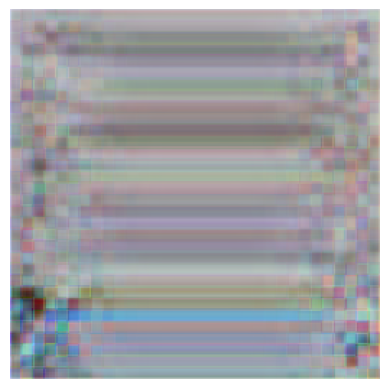

In [ ]:
import matplotlib.pyplot as plt
# Move tensor to CPU, detach it, and extract the desired frame
frame = predicted_frame.cpu().detach()
f = frame[1, :, :, :]  # Assuming this is the desired frame (C, H, W)
# Convert to NumPy and transpose if necessary
if f.shape[0] in [3, 4]:  # Check if the first dimension is channels
    f = f.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
else:
    f = f.numpy()  # For grayscale (H, W)
# Normalize the data to [0, 1] if necessary
f = (f - f.min()) / (f.max() - f.min())  # Normalization for display
# Plot the image
plt.imshow(f)
plt.axis('off')  # Optional: Hide axis for cleaner display
plt.show()


In [6]:
import torch
import numpy as np

# Load your trained decoder model
# Assuming `Decoder` is your trained model class
# decoder = torch.load("frame_prediction_decoder_rgb.pth")
decoder.eval()  # Set the model to evaluation mode

# Load the test input
test_input = np.load("Test_inputs/test_original_encoder_output.npy")  # Shape: (25, 512, 1, 32, 32)
test_input = test_input[:, :7, :, :]  # Select the first 7 channels (adjust as needed)
test_input = torch.tensor(test_input, dtype=torch.float32)  # Convert to torch tensor
test_input = test_input.squeeze(2)  # Remove the channel dimension, now it should be (25, 512, 32, 32)

# Perform inference using the trained decoder model
with torch.no_grad():  # Disable gradient calculation for inference
    predicted_frames = decoder(test_input)  # Predicted frames: Shape (25, 3, 256, 256)

# Load the ground-truth target frames
target_frames = np.load("test_original_input.npy")  # Shape: (25, 3, 256, 256)
target_frames = target_frames.reshape(25, 8, 3, 256, 256)
target_frames=target_frames[:,7,:,:,:]
target_frames = torch.tensor(target_frames, dtype=torch.float32)

# Ensure shape consistency between predicted and target frames
assert predicted_frames.shape == target_frames.shape, "Shape mismatch between predicted and target frames!"

# PSNR Computation Function
def compute_psnr(predicted, target, max_val=1.0):
    """
    Compute PSNR between predicted and target frames.
    Args:
    - predicted (Tensor): Predicted frame
    - target (Tensor): Target ground-truth frame
    - max_val (float): Maximum pixel value, typically 1.0 for normalized images
    Returns:
    - psnr (float): PSNR value in decibels (dB)
    """
    mse = torch.mean((predicted - target) ** 2)  # Mean Squared Error
    if mse == 0:
        return float("inf")  # Infinite PSNR for identical images
    psnr = 10 * torch.log10(max_val / torch.sqrt(mse))  # PSNR formula in dB
    return psnr.item()  # Return as a standard Python number

# Compute PSNR for all frames in the batch
psnr_scores = []

for i in range(predicted_frames.shape[0]):  # Iterate over batch dimension
    # Compute PSNR for the current frame
    psnr = compute_psnr(predicted_frames[i], target_frames[i])
    psnr_scores.append(psnr)

# Convert PSNR scores into a numpy array for easy processing
psnr_scores = np.array(psnr_scores)

# Print average PSNR for the batch
avg_psnr = np.mean(psnr_scores)
print(f"Average PSNR for all frames: {avg_psnr:.4f} dB")

Average PSNR for all frames: 1.7283 dB


In [163]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Assuming `Decoder` is your trained model class
# Load your trained decoder model
# decoder = torch.load("decoder_model_frame.pth")
decoder.eval()  # Set the model to evaluation mode

# Load the test input
test_input = np.load("Test_inputs/test3_original_encoder_output.npy")  # Shape: (25, 512, 1, 32, 32)
test_input = torch.tensor(test_input, dtype=torch.float32)  # Convert to torch tensor
test_input = test_input.squeeze(2)  # Remove the channel dimension, now it should be (25, 512, 32, 32)

# Perform inference using the trained decoder model
with torch.no_grad():  # Disable gradient calculation for inference
    predicted_frames = decoder(test_input)  # Predicted frames: Shape (25, 8, 3, 256, 256)

# Define PSNR computation function
def compute_psnr(predicted, target, max_val=1.0):
    """
    Compute PSNR between predicted and target frames with output in range [0, 1].
    Args:
    - predicted (Tensor or np.array): Predicted frame
    - target (Tensor or np.array): Target ground-truth frame
    - max_val (float): Maximum pixel value, typically 1.0 for normalized images [-1, 1]
    Returns:
    - psnr (float): PSNR value in range [0, 1]
    """
    # Convert inputs to tensors if they aren't already
    predicted = torch.tensor(predicted) if not isinstance(predicted, torch.Tensor) else predicted
    target = torch.tensor(target) if not isinstance(target, torch.Tensor) else target
    
    # Compute MSE (Mean Squared Error)
    mse = torch.mean((predicted - target) ** 2)
    
    # Compute PSNR
    psnr = torch.exp(-mse / (2 * max_val ** 2))
    return psnr.item()  # Return as a standard Python number

# Loop over the test frames and compute PSNR
# Assuming you have ground-truth frames for comparison, e.g., 'target_frames'
target_frames = np.load("test3_original_input.npy")  # Shape: (25, 8, 3, 256, 256)
target_frames = target_frames.reshape(25, 8, 3, 256, 256)
target_frames = torch.tensor(target_frames, dtype=torch.float32)

# Check shape consistency
assert predicted_frames.shape == target_frames.shape, "Shape mismatch between predicted and target frames!"

psnr_scores = []
# Compute PSNR for each frame in the batch
# for i in range(predicted_frames.shape[0]):  # Loop through each batch in the batch dimension
#     # Compute PSNR for all frames in the current batch
#     psnr_batch = [compute_psnr(predicted_frames[i, j], target_frames[i, j]) for j in range(predicted_frames.shape[1])]
#     psnr_scores.append(psnr_batch)

# # Convert list of PSNRs into a numpy array for easy processing
# psnr_scores = np.array(psnr_scores)

# # Print average PSNR for the batch
# avg_psnr = np.mean(psnr_scores)
# print(f"Average PSNR for the batch: {avg_psnr:.4f} dB")

# Initialize variable to store PSNR scores
# Compute PSNR for each frame in the batch


# # Flatten the frames (25*8 = 200 frames) for computing PSNR
for i in range(predicted_frames.shape[0]):  # Iterate over the batch dimension
    for j in range(predicted_frames.shape[1]):  # Iterate over the 8 frames in each batch
        # Compute PSNR for the current frame
        psnr = compute_psnr(predicted_frames[i, j], target_frames[i, j])
        psnr_scores.append(psnr)

# Convert list of PSNRs into a numpy array for easy processing
psnr_scores2 = np.array(psnr_scores)

# Print average PSNR for the batch
avg_psnr = np.mean(psnr_scores2)
print(f"Average PSNR for all frames: {avg_psnr:.4f} dB")

Average PSNR for all frames: 0.8286 dB


In [181]:
print(len(psnr_scores))
print(len(psnr_scores2))

25
200


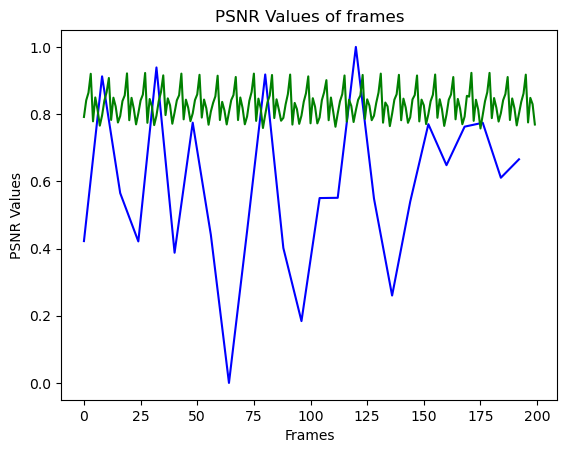

In [189]:
# print(len(psnr_scores[0]))
import matplotlib.pyplot as plt
min_score_frame = np.min(psnr_scores)
max_score_frame = np.max(psnr_scores)
regularity_scores_frame=(psnr_scores - min_score_frame) / (max_score_frame - min_score_frame)
# print(regularity_scores_frame)
# min_score_frame2 = np.min(psnr_scores2)
# max_score_frame2 = np.max(psnr_scores2)
# regularity_scores_frame2=(psnr_scores2 - min_score_frame2) / (max_score_frame2 - min_score_frame2)

# print(regularity_scores_frame2)
plt.Figure(figsize=(5,2))
y=[]
for i in range(200):
    y.append(i)
x = [i * 8 for i in range(len(psnr_scores))]
plt.plot(x,regularity_scores_frame, label='Frame Prediction', linestyle='-', color='blue')
plt.plot(y,psnr_scores2, label='Frame Reconstruction', color='green')
plt.xlabel("Frames")
plt.ylabel("PSNR Values")
plt.title("PSNR Values of frames")
plt.savefig("psnr_test1.png")
plt.show()

In [7]:
#augmented encoder outputs
shuffle_encoder = pre_encoder(shuffle_batch_tensor)
print("Output shape:", shuffle_encoder.shape)
np.save('shuffle_encoder_output.npy', shuffle_encoder.cpu().detach().numpy())

# jittered_encoder = encoder(jittered_batch_tensor)
# print("Output shape:", jittered_encoder.shape)
# speed_encoder = encoder(speed_batch_tensor)
# print("Output shape:", speed_encoder.shape)
# shuffle_encoder = encoder(shuffle_batch_tensor)
# print("Output shape:", shuffle_encoder.shape)

Output shape: torch.Size([25, 512, 1, 32, 32])


In [161]:
import os
import numpy as np
import torch
def load_groundtruth(output_dir, snippet_idx,types):
    """Load the one-hot encoded ground truth from a text file."""
    gt_filename = os.path.join(output_dir,f"groundtruth_{types}_{snippet_idx}.txt")
    if os.path.exists(gt_filename):
        return np.loadtxt(gt_filename, dtype=np.int32)
    else:
        raise FileNotFoundError(f"Ground truth file {gt_filename} not found.")
    
# Load the groundtruth labels for training
def load_groundtruths_for_training(output_dir, num_snippets,types):
    """Load all groundtruth files for training."""
    labels = []
    for snippet_idx in range(num_snippets):
           labels.append(load_groundtruth(output_dir, snippet_idx,types))
    return torch.tensor((np.array(labels)), dtype=torch.float32)
gt_file1=r'DL_project_final\output_groundtruths\augmented'
gt_file2=r'DL_project_final\output_groundtruths\rotation'


In [ ]:
# Load the best model state if desired
# model.load_state_dict(best_model_state)

<All keys matched successfully>

In [22]:
def to_one_hot(labels, num_classes=25):
    # Convert integer labels to one-hot encoding
    # labels shape: (batch_size,)
    one_hot = torch.zeros((labels.size(0), num_classes)).to(labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot
def compute_loss(predictions, labels):
    # predictions: Shape (batch_size, 25) after softmax
    # labels: One-hot encoded shape (batch_size, 25)
    loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
    # Compute loss
    losses = loss_fn(predictions, labels)
    return losses


In [138]:

# Load the encoder outputs (example)
original_encoder_output = np.load('original_encoder_output.npy')  # Shape: (25, 512, 1, 32, 32)
reverse_encoder_output = np.load('reverse_encoder_output.npy')  # Shape: (25, 512, 1, 32, 32)
shuffle_encoder_output = np.load('shuffle_encoder_output.npy')  # Shape: (25, 512, 1, 32, 32)
speed_encoder_output = np.load('speed_encoder_output.npy')  # Shape: (25, 512, 1, 32, 32)
jittered_encoder_output = np.load('rotation_encoder_output.npy')  # Shape: (25, 512, 1, 32, 32)

# Convert to torch tensors and squeeze out the singleton dimension
original_encoder_output = torch.tensor(original_encoder_output).float().squeeze(2)  # Shape: (25, 512, 32, 32)
reverse_encoder_output = torch.tensor(reverse_encoder_output).float().squeeze(2)  # Shape: (25, 512, 32, 32)
shuffle_encoder_output = torch.tensor(shuffle_encoder_output).float().squeeze(2)  # Shape: (25, 512, 32, 32)
speed_encoder_output = torch.tensor(speed_encoder_output).float().squeeze(2)  # Shape: (25, 512, 32, 32)
jittered_encoder_output = torch.tensor(jittered_encoder_output).float().squeeze(2)  # Shape: (25, 512, 32, 32)



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Check if GPU is available and set the device
device = torch.device("cpu")

# Contrastive Loss Function (InfoNCE)
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):  
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, q, k):
        # Normalize the query and key vectors to unit length
        q = F.normalize(q, dim=-1, p=2)
        k = F.normalize(k, dim=-1, p=2)

        # Compute cosine similarity (dot product) between query and key
        similarity = torch.matmul(q, k.T) / self.temperature

        # Labels: diagonal elements (positive pairs)
        labels = torch.arange(q.size(0)).to(q.device)

        # Cross-entropy loss (InfoNCE loss)
        loss = F.cross_entropy(similarity, labels)
        
        return loss

# MoCo V2 Model with Momentum Encoder
class MoCoV2(nn.Module):
    def __init__(self, input_channels=512, projection_dim=128, momentum=0.999):
        super(MoCoV2, self).__init__()
        self.projection_dim = projection_dim
        self.momentum = momentum
        
        # Input dimensions
        self.input_channels = input_channels  # 512 channels
        self.input_size = 32  # Spatial size: 32x32

        # Flattening layer to match the input size: (batch_size, 512, 32, 32) -> (batch_size, 512 * 32 * 32)
        self.flatten = nn.Flatten(start_dim=1)

        # Projection head (shared between query and key)
        self.proj_head = nn.Sequential(
            nn.Linear(self.input_channels * self.input_size * self.input_size, 2048),  # Linear layer for projection
            nn.ReLU(),
            nn.Linear(2048, self.projection_dim)  # Final projection layer to the desired projection_dim (128)
        )
        
        # Initialize weights using Xavier initialization
        for m in self.proj_head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        # Create a momentum encoder with the same architecture
        self.momentum_encoder = nn.Sequential(
            nn.Linear(self.input_channels * self.input_size * self.input_size, 2048),
            nn.ReLU(),
            nn.Linear(2048, self.projection_dim)
        )
        self.update_momentum_encoder()

    def forward(self, x_q, x_k):
        # Flatten the input tensors to match the shape of the projection head
        x_q = self.flatten(x_q)
        x_k = self.flatten(x_k)
        
        # Apply projection head for query
        q = self.proj_head(x_q)
        # Apply momentum encoder for key
        with torch.no_grad():  # No gradient computation for momentum encoder
            k = self.momentum_encoder(x_k)
        
        return q, k

    def update_momentum_encoder(self):
        """ Update momentum encoder weights using moving average """
        for param_q, param_k in zip(self.proj_head.parameters(), self.momentum_encoder.parameters()):
            param_k.data = param_k.data * self.momentum + param_q.data * (1. - self.momentum)
            
projection_dim = 128  # Projection dimension can be adjusted, but 128 is a common choice
moco_model = MoCoV2(input_channels=512, projection_dim=projection_dim).to(device)

In [ ]:

# Move the data to the GPU
original_encoder_output = original_encoder_output.to(device)
reverse_encoder_output = reverse_encoder_output.to(device)
shuffle_encoder_output = shuffle_encoder_output.to(device)
speed_encoder_output = speed_encoder_output.to(device)
jittered_encoder_output = jittered_encoder_output.to(device)
# Instantiate the MoCo V2 model and move to the GPU

# Contrastive loss function
contrastive_loss_fn = ContrastiveLoss(temperature=0.07)

# Optimizer (lower learning rate)
optimizer = optim.SGD(moco_model.proj_head.parameters(), lr=0.001, momentum=0.9)

# Function to save the best model based on minimum loss
def save_best_model(model, path, best_loss, current_loss):
    if current_loss < best_loss:
        best_loss = current_loss
        torch.save(model.state_dict(), path)
        print(f"Best model saved with loss: {best_loss:.4f}")
    return best_loss

# Training function
def train_moco(model, data_q, data_k_all, optimizer, contrastive_loss):
    model.train()

    total_loss = 0.0

    for data_k in data_k_all:  # Loop over each augmentation task
        # Forward pass for query and key (for the current task)
        q, k = model(data_q, data_k)
        
        # Compute contrastive loss for the current task
        loss = contrastive_loss(q, k)
        total_loss += loss

    # Average the total loss from all tasks
    total_loss /= len(data_k_all)

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()

    # Clip gradients to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    # Update momentum encoder
    model.update_momentum_encoder()

    return total_loss.item()



# Combine all the augmented data into a list
data_k_all = [reverse_encoder_output, shuffle_encoder_output, speed_encoder_output, jittered_encoder_output]

# Initialize the best loss
best_loss = float('inf')
best_model_path = "best_moco_model.pth"
num_epochs=100
# Training for a few epochs
for epoch in range(num_epochs):  # You can adjust the number of epochs
    # Training for a few epochs
    loss = train_moco(moco_model, original_encoder_output, data_k_all, optimizer, contrastive_loss_fn)
    
    # Print loss for the current epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss after epoch {epoch+1}: {loss:.4f}")
    
    # Save the best model based on the current loss
    best_loss = save_best_model(moco_model, best_model_path, best_loss, loss)

# After training, the model with the least loss will be saved as 'best_moco_model.pth'



Epoch [1/50], Loss after epoch 1: 3.6103
Best model saved with loss: 3.6103

Epoch [2/50], Loss after epoch 2: 3.5594
Best model saved with loss: 3.5594

Epoch [3/50], Loss after epoch 3: 3.4651
Best model saved with loss: 3.4651

Epoch [4/50], Loss after epoch 4: 3.3353
Best model saved with loss: 3.3353

Epoch [5/50], Loss after epoch 5: 3.1786
Best model saved with loss: 3.1786

Epoch [6/50], Loss after epoch 6: 3.0026
Best model saved with loss: 3.0026

Epoch [7/50], Loss after epoch 7: 2.8142
Best model saved with loss: 2.8142

Epoch [8/50], Loss after epoch 8: 2.6167
Best model saved with loss: 2.6167

Epoch [9/50], Loss after epoch 9: 2.4130
Best model saved with loss: 2.4130

Epoch [10/50], Loss after epoch 10: 2.2038
Best model saved with loss: 2.2038

Epoch [11/50], Loss after epoch 11: 1.9904
Best model saved with loss: 1.9904

Epoch [12/50], Loss after epoch 12: 1.7738
Best model saved with loss: 1.7738

Epoch [13/50], Loss after epoch 13: 1.5588
Best model saved with loss

In [8]:
import torch
import torch.nn.functional as F
import numpy as np

# Function to compute contrastive similarity between features
def compute_similarity(features_1, features_2, temperature=0.07):
    """
    Computes the contrastive similarity between two sets of features using cosine similarity.
    Arguments:
    - features_1, features_2: Tensors of shape (batch_size, feature_dim)
    - temperature: Scaling factor for the similarity
    Returns:
    - similarity: Tensor of shape (batch_size)
    """
    # Normalize the features (l2 normalization)
    features_1 = F.normalize(features_1, dim=-1, p=2)
    features_2 = F.normalize(features_2, dim=-1, p=2)
    
    # Compute cosine similarity
    similarity = torch.matmul(features_1, features_2.T) / temperature
    return similarity

# Function to calculate the regularity score (S_Tcon) for each snippet in the batch
def calculate_regularity_score(model, original_data, augmented_data_all, temperature=0.07):
    """
    Calculates the regularity score (S_Tcon) based on contrastive similarity between features.
    Arguments:
    - model: The trained MoCoV2 model
    - original_data: Tensor of original encoder features (batch_size, feature_dim)
    - augmented_data_all: List of augmented data tensors (batch_size, feature_dim) for different augmentations
    - temperature: Scaling factor for similarity calculation
    Returns:
    - regularity_scores: List of mean contrastive similarities for each snippet (size: batch_size)
    """
    model.eval()  # Set model to evaluation mode

    # Initialize list to store regularity scores for each snippet
    regularity_scores_cl = []

    with torch.no_grad():
        # Extract features for the original data (query)
        original_features = model.flatten(original_data)
        original_features = model.proj_head(original_features)
        
        # List to store similarity scores for each snippet
        all_snippet_similarities = []

        # Compare original features with each augmented data set (reverse, shuffle, speed, jittered)
        for augmented_data in augmented_data_all:
            augmented_features = model.flatten(augmented_data)
            augmented_features = model.proj_head(augmented_features)
            
            # Calculate similarity between the original features and augmented features
            similarity = compute_similarity(original_features, augmented_features, temperature)
            
            # Append similarity for all snippets
            all_snippet_similarities.append(similarity)

        # For each snippet, calculate the mean similarity across all augmented versions
        for i in range(original_data.size(0)):  # Iterate through all snippets in the batch
            mean_similarity = torch.mean(torch.stack([all_snippet_similarities[j][i] for j in range(len(all_snippet_similarities))]))
            regularity_scores_cl.append(mean_similarity.item())  # Convert tensor to float and append to list

    # Return the list of regularity scores (one per snippet)
    return regularity_scores_cl
# Load the test data (from the provided paths)
test_original_encoder = torch.tensor(np.load(r'Test_inputs/test_original_encoder_output.npy')).float().to(device)
test_reverse_encoder = torch.tensor(np.load(r'Test_inputs/test_reverse_encoder_output.npy')).float().to(device)
test_shuffle_encoder = torch.tensor(np.load(r'Test_inputs/test_shuffle_encoder_output.npy')).float().to(device)
test_speed_encoder = torch.tensor(np.load(r'Test_inputs/test_speed_encoder_output.npy')).float().to(device)
test_jittered_encoder = torch.tensor(np.load(r'Test_inputs/test_jittered_encoder_output.npy')).float().to(device)

# Combine the augmented data into a list
test_augmented_data_all = [
    test_reverse_encoder, 
    test_shuffle_encoder, 
    test_speed_encoder, 
    test_jittered_encoder
]

# Evaluate the model with the test data
# Load the best model
best_model_path = "best_moco_model.pth"
moco_model.load_state_dict(torch.load(best_model_path))

# Calculate the regularity scores for all 25 snippets in the batch
regularity_scores_cl = calculate_regularity_score(moco_model, test_original_encoder, test_augmented_data_all)
print(len(regularity_scores_cl))
print(regularity_scores_cl[0])
# Output the list of regularity scores for all 25 snippets
# print("List of Regularity Scores (S_Tcon) for each snippet in the batch:")
# for idx, score in enumerate(regularity_scores):
#     print(f"Snippet {idx + 1}: {score}")


25
5.501970291137695


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a single Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Define a series of layers to handle the spatial dimension of each snippet
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Input: (1, 32, 32), Output: (64, 32, 32)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: (128, 32, 32)
        
        # Flatten the feature maps for the fully connected layer
        self.fc = nn.Linear(128 * 32 * 32, 512)

    def forward(self, x):
        # x shape: (batch_size * num_snippets, 1, 32, 32)
        x = F.relu(self.conv1(x))  # Output shape: (batch_size * num_snippets, 64, 32, 32)
        x = F.relu(self.conv2(x))  # Output shape: (batch_size * num_snippets, 128, 32, 32)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size * num_snippets, 128 * 32 * 32)
        x = self.fc(x)  # Output shape: (batch_size * num_snippets, 512)
        return x  # Returns encoded features per snippet

# Define Task Heads for each classification task
class TaskHead(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(TaskHead, self).__init__()
        # First fully connected layer
        self.fc = nn.Linear(input_dim, 256)
        # Output layer with the specified number of labels
        self.out = nn.Linear(256, num_labels)

    def forward(self, x):
        x = F.relu(self.fc(x))  # Apply ReLU activation
        x = self.out(x)  # Final output with shape (batch_size, num_labels)
        return x

# Define the combined self-supervised model with one encoder and multiple task heads
class SelfSupervisedModel(nn.Module):
    def __init__(self, input_dim=512, num_labels_task1=2, num_labels_task2=4):
        super(SelfSupervisedModel, self).__init__()
        self.encoder = Encoder()
        self.task_head1 = TaskHead(input_dim, num_labels_task1)  # Task head for the first task (e.g., augmented)
        self.task_head2 = TaskHead(input_dim, num_labels_task2)  # Task head for the second task (e.g., rotation)

    def forward(self, snippet_batch, task="task1"):
        # snippet_batch shape: (batch_size, num_snippets, channels, height, width)
        batch_size, num_snippets, channels, height, width = snippet_batch.shape
        # Reshape to (batch_size * num_snippets, channels, height, width) to feed into encoder
        snippets = snippet_batch.reshape(batch_size * num_snippets, channels, height, width)
        # Encode each snippet
        encoded_features = self.encoder(snippets)  # Shape: (batch_size * num_snippets, 512)
        # Reshape back to (batch_size, num_snippets, feature_dim)
        encoded_features = encoded_features.view(batch_size, num_snippets, -1)  # Shape: (batch_size, num_snippets, 512)
        # Aggregate over all snippets (e.g., by averaging)
        aggregated_features = encoded_features.mean(dim=1)  # Shape: (batch_size, 512)

        # Use the appropriate task head based on the task type
        if task == "task1":
            outputs = self.task_head1(aggregated_features)  # Task 1 (e.g., augmented)
        elif task == "task2":
            outputs = self.task_head2(aggregated_features)  # Task 2 (e.g., rotation)
        else:
            raise ValueError("Unknown task specified. Choose 'task1' or 'task2'.")

        return aggregated_features, outputs  # Return aggregated features and outputs


In [ ]:
# Initialize the model, optimizer, and device
input_dim = 512
num_classes_task1 = 2  # Number of classes for the first task (e.g., augmented)
num_classes_task2 = 4  # Number of classes for the second task (e.g., rotation)
num_epochs = 100
num_snippets=25
device = torch.device("cpu")

# Single model with two task heads
model = SelfSupervisedModel(input_dim=input_dim, num_labels_task1=num_classes_task1, num_labels_task2=num_classes_task2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Integer labels ranging from 0 to 24
augmented_labels_path=r'DL_project_final\output_groundtruths\augmented'
augmented_labels = load_groundtruths_for_training(augmented_labels_path,num_snippets,'augmented')
# print(augmented_labels.shape)  # Expected shape: (25,2)
rotation_labels_path=r'DL_project_final\output_groundtruths\rotation'
rotation_labels = load_groundtruths_for_training(rotation_labels_path,num_snippets,'rotation')
# print(augmented_labels.shape)  # Expected shape: (25,2)

# Move data to device
reverse_encoder = reverse_encoder.to(device)
shuffle_encoder = shuffle_encoder.to(device)
speed_encoder = speed_encoder.to(device)
jittered_encoder = jittered_encoder.to(device)
augmented_labels = augmented_labels.to(device)
rotation_labels = rotation_labels.to(device)
augmented_labels = torch.argmax(augmented_labels, dim=1)  # Shape: (25,)
rotation_labels = torch.argmax(rotation_labels, dim=1)    # Shape: (25,)
# Specify the directory where you want to save the model
save_directory = "DL_project_final"  # Replace with the desired folder path
os.makedirs(save_directory, exist_ok=True)

# Specify the filename for saving the model
model_filename = "best_model_checkpoint.pth"
model_save_path = os.path.join(save_directory, model_filename)


# Loss function
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
best_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear previous gradients

    # Task 1 (augmented): reverse, shuffle, speed
    _, logits1 = model(reverse_encoder, task="task1")
    _, logits2 = model(shuffle_encoder, task="task1")
    _, logits3 = model(speed_encoder, task="task1")

    loss1 = criterion(logits1, augmented_labels)
    loss2 = criterion(logits2, augmented_labels)
    loss3 = criterion(logits3, augmented_labels)

    # Task 2 (rotation): jittered
    _, logits4 = model(jittered_encoder, task="task2")
    loss4 = criterion(logits4, rotation_labels)

    # Combine all four losses
    total_loss = loss1 + loss2 + loss3 + loss4

    # Backpropagation
    total_loss.backward()  # Calculate gradients based on the combined loss
    optimizer.step()  # Update model parameters

    # Track best model based on total loss
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_loss': best_loss
        }
        torch.save(checkpoint, model_save_path)
    # Clear CUDA cache if using GPU to avoid memory buildup
    torch.cuda.empty_cache()

    # Output loss for monitoring
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}, Loss3: {loss3.item():.4f}, Loss4: {loss4.item():.4f}, Total Loss: {total_loss.item():.4f}")
best_model_state_last = model.state_dict() 
model_filename_last = "best_model_last.pth"
model_save_path = os.path.join(save_directory, model_filename_last)
torch.save(best_model_state_last, model_save_path)
# Load the best model after training if needed:
# model.load_state_dict(best_model_state)


Epoch [1/50], Loss1: 0.6991, Loss2: 0.6985, Loss3: 0.6984, Loss4: 1.3879, Total Loss: 3.4840
Epoch [2/50], Loss1: 0.0000, Loss2: 0.0000, Loss3: 0.0000, Loss4: 3.4715, Total Loss: 3.4715
Epoch [3/50], Loss1: 0.0000, Loss2: 0.0000, Loss3: 0.0000, Loss4: 10.9107, Total Loss: 10.9107
Epoch [4/50], Loss1: 0.0000, Loss2: 0.0000, Loss3: 0.0000, Loss4: 10.9035, Total Loss: 10.9035
Epoch [5/50], Loss1: 0.0000, Loss2: 0.0000, Loss3: 0.0000, Loss4: 4.8021, Total Loss: 4.8021
Epoch [6/50], Loss1: 0.0002, Loss2: 0.0002, Loss3: 0.0001, Loss4: 2.4542, Total Loss: 2.4546
Epoch [7/50], Loss1: 0.0142, Loss2: 0.0140, Loss3: 0.0136, Loss4: 1.5765, Total Loss: 1.6182
Epoch [8/50], Loss1: 0.1342, Loss2: 0.1332, Loss3: 0.1315, Loss4: 1.4193, Total Loss: 1.8181
Epoch [9/50], Loss1: 0.2414, Loss2: 0.2392, Loss3: 0.2373, Loss4: 1.3946, Total Loss: 2.1126
Epoch [10/50], Loss1: 0.2069, Loss2: 0.2043, Loss3: 0.2024, Loss4: 1.3871, Total Loss: 2.0007
Epoch [11/50], Loss1: 0.0947, Loss2: 0.0927, Loss3: 0.0912, Loss4

In [ ]:
# Create the model and optimizer with the same settings as before
model = SelfSupervisedModel(input_dim=input_dim, num_labels_task1=num_classes_task1, num_labels_task2=num_classes_task2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load the saved checkpoint
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If you want to resume training, load the epoch and best_loss too
epoch = checkpoint['epoch']
best_loss = checkpoint['best_loss']

# Set the model to training mode if you are continuing training
model.train()  # Use this line if you are resuming training


In [ ]:
import os
import numpy as np
from PIL import Image
import random

def temporal_reverse(snippet):
    """Reverse the order of frames in the snippet."""
    return snippet[::-1]

def jittered_rotation(snippet):
    """Apply jittered rotations (0°, 90°, 180°, 270°) plus random noise [-3°, 3°]."""
    rotated_snippet = []
    rotation_classes = []  # Keep track of the base rotation class for labeling
    for frame in snippet:
        base_angle = random.choice([0, 90, 180, 270])
        noise = random.uniform(-3, 3)  # Random noise in [-3°, 3°]
        total_rotation = base_angle + noise
        # Convert the base angle to class for labeling
        if base_angle == 0:
            rotation_class = 0
        elif base_angle == 90:
            rotation_class = 1
        elif base_angle == 180:
            rotation_class = 2
        elif base_angle == 270:
            rotation_class = 3
        # Assuming frame is a numpy array, apply the rotation
        rotated_frame = np.rot90(frame, k=total_rotation // 90)  # Quick rotation by 90° multiples
        rotated_snippet.append(rotated_frame)
        rotation_classes.append(rotation_class)
    # Use the most frequent rotation class in the snippet for labeling
    dominant_class = max(set(rotation_classes), key=rotation_classes.count)
    return rotated_snippet, dominant_class

def shuffle_snippet(snippet):
    """Randomly shuffle the order of frames in the snippet."""
    shuffled_snippet = snippet.copy()
    random.shuffle(shuffled_snippet)
    return shuffled_snippet

def vary_speed(snippet, speed_factor=2):
    """Adjust the speed of the snippet by changing the sampling rate."""
    if speed_factor > 1:
        adjusted_snippet = snippet[::int(speed_factor)]  # Fast-forward
    elif speed_factor < 1:
        adjusted_snippet = []
        repeat_factor = int(1 / speed_factor)  # Slow-motion
        for frame in snippet:
            adjusted_snippet.extend([frame] * repeat_factor)
    else:
        adjusted_snippet = snippet  # No change for speed_factor == 1
    return adjusted_snippet

def convert_to_three_channels(frame):
    """Convert a 2D grayscale frame to 3 channels (RGB)."""
    return np.stack([frame] * 3, axis=-1)

def save_groundtruth(groundtruth, gt_file, snippet_idx,types):
    """Save ground truth to a text file (one-hot encoded)."""
    gt_filename = os.path.join(gt_file, types, f"groundtruth_{types}_{snippet_idx}.txt")
    np.savetxt(gt_filename, groundtruth, fmt='%d')

def data_generator(data_path, snippet_length=10,gt_file=None, transformations=None):
    """Generator that yields augmented video snippets on-the-fly."""
    video_dirs = sorted(os.listdir(data_path))
    
    # Initialize lists to hold all transformations
    all_originals = []
    all_temporal_reverses = []
    all_shuffles = []
    all_jittered_rotations = []
    all_speed_variations = []
    snippet_idx = 0
    for video_dir in video_dirs:
        video_path = os.path.join(data_path, video_dir)
        
        # Read frames assuming they are TIFF images
        frames = []
        for f in sorted(os.listdir(video_path)):
            if f.endswith('.tif'):
                # Open the TIFF image and convert to 3-channel format
                frame = np.array(Image.open(os.path.join(video_path, f)))
                frame_3channel = convert_to_three_channels(frame)  # Convert to 3 channels
                frames.append(frame_3channel)
            else:
                continue
        
        # Divide the video into snippets
        for start in range(0, len(frames) - snippet_length + 1, snippet_length):
            snippet = frames[start:start + snippet_length]
            # Apply transformations
            original = snippet
            temporal_reverse_snippet = temporal_reverse(snippet)
            shuffled_snippet = shuffle_snippet(snippet)
            speed_variation_snippet = vary_speed(snippet, speed_factor=random.choice([0.5, 2]))  # Random speed variation
            jittered_rotation_snippet, dominant_class = jittered_rotation(snippet)
            groundtruth_jittered = np.zeros(4, dtype=int)
            groundtruth_jittered[dominant_class] = 1
            groundtruth_original = np.array([0, 1])  # Class 1: [0,1] for original
            groundtruth_augmented = np.array([1,0])  # Class 0: [1,0] for augmentation
            save_groundtruth(groundtruth_original, gt_file, snippet_idx,'original')  # For original order
            save_groundtruth(groundtruth_jittered, gt_file, snippet_idx,'rotation')
            save_groundtruth(groundtruth_augmented, gt_file, snippet_idx,'augmented')  # For speed-adjusted order
            # Append to the lists
            all_originals.append(original)
            all_temporal_reverses.append(temporal_reverse_snippet)
            all_shuffles.append(shuffled_snippet)
            all_jittered_rotations.append(jittered_rotation_snippet)
            all_speed_variations.append(speed_variation_snippet)
            snippet_idx += 1
    # Yield the entire lists of transformations
    return {
        "test": all_originals,
        "reverse": all_temporal_reverses,
        "shuffle": all_shuffles,
        "rotation": all_jittered_rotations,
        "speed": all_speed_variations
    }

# Example usage:
data_path = r"Test_inputs/Test014_gt"
gt_file=r"test_gt1"
snippet_length = 8  # Length of the video snippet
transformations = {
    "reverse": temporal_reverse,
    "rotation": jittered_rotation,
    "shuffle": shuffle_snippet,
    "speed": vary_speed
}

# Using the generator to get all snippets for all transformations
test_augmented_snippets = data_generator(data_path, snippet_length,gt_file, transformations)

# Accessing the transformed snippets
print(f"Total Original Snippets: {len(test_augmented_snippets['test'])}")
print(f"Total Temporal Reverse Snippets: {len(test_augmented_snippets['reverse'])}")
print(f"Total Shuffle Snippets: {len(test_augmented_snippets['shuffle'])}")
print(f"Total Jittered Rotation Snippets: {len(test_augmented_snippets['rotation'])}")
print(f"Total Speed Variation Snippets: {len(test_augmented_snippets['speed'])}")

Total Original Snippets: 25
Total Temporal Reverse Snippets: 25
Total Shuffle Snippets: 25
Total Jittered Rotation Snippets: 25
Total Speed Variation Snippets: 25


In [115]:
import torch
import cv2
import numpy as np

def resize_frame(frame, target_height=256, target_width=256):
    """Resize a single frame to the target resolution."""
    return cv2.resize(frame, (target_width, target_height))

def normalize_frame(frame):
    """Normalize frame to the range [-1, 1]."""
    return (frame / 127.5) - 1.0

def convert_to_three_channels(frame):
    """Convert a 2D grayscale frame to 3 channels (RGB)."""
    return np.stack([frame] * 3, axis=-1)

def preprocess_snippets_for_encoding(augmented_snippets, batch_size=25, snippet_length=8, target_height=256, target_width=256,var='original'):
    """
    Convert the augmented snippets into the required shape (B, C, T, H, W).
    B = batch size, C = 3 channels (RGB), T = 8 frames per snippet,
    H = 256 (height), W = 256 (width).
    """
    # Initialize a list to store batches
    batch_data = []

    # Iterate over the augmented snippets to create the batch
    for i in range(batch_size):
        snippet = augmented_snippets[var][i][1]  # Get the snippet of interest (change as necessary)

        # Resize and normalize each frame to 3 channels
        snippet_3_channels = [
            convert_to_three_channels(normalize_frame(resize_frame(frame, target_height, target_width)))
            for frame in snippet[:snippet_length]  # Ensure you only take the first 'snippet_length' frames
        ]

        # Stack the frames together to form a tensor of shape (T, H, W, 3)
        snippet_tensor = np.stack(snippet_3_channels, axis=0)  # Shape: (T, H, W, 3)

        # Convert to (T, 3, H, W) shape by reordering axes
        snippet_tensor = np.transpose(snippet_tensor, (0, 3, 1, 2))  # Shape: (T, 3, H, W)

        # Append the snippet to the batch
        batch_data.append(snippet_tensor)

    # Stack all snippets to form the final batch (B, T, 3, H, W)
    final_batch = np.stack(batch_data, axis=0)  # Shape: (B, T, 3, H, W)
    # Now reorder the dimensions to match the expected shape (B, C, T, H, W)
    final_batch = final_batch.transpose(0, 2, 1, 3, 4)  # (B, C, T, H, W)
    # Convert the final batch to a PyTorch tensor
    final_batch_tensor = torch.tensor(final_batch, dtype=torch.float32)
    return final_batch_tensor

batch_size=len(test_augmented_snippets['test']) 
snippet_length=snippet_length
target_height,target_width,_=test_augmented_snippets['test'][0][1].shape
variables=['test','reverse','shuffle','rotation','speed']

# Preprocess snippets for encoding
test_original_batch_tensor = preprocess_snippets_for_encoding(test_augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[0])
test_reverse_batch_tensor = preprocess_snippets_for_encoding(test_augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[1])
test_shuffle_batch_tensor = preprocess_snippets_for_encoding(test_augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[2])
test_jittered_batch_tensor = preprocess_snippets_for_encoding(test_augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[3])
test_speed_batch_tensor = preprocess_snippets_for_encoding(test_augmented_snippets, batch_size=batch_size, snippet_length=snippet_length,var=variables[4])
# Check the shape
print(test_original_batch_tensor.shape)  # Expected shape: (25, 3, 8, 256, 256)
print(test_reverse_batch_tensor.shape)
print(test_shuffle_batch_tensor.shape)
print(test_jittered_batch_tensor.shape)
print(test_speed_batch_tensor.shape)

torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])
torch.Size([25, 3, 8, 256, 256])


In [116]:
np.save('test2_original_input.npy',test_original_batch_tensor)

In [ ]:
test_encoder = pre_encoder(test_original_batch_tensor)

print("Output shape:", test_encoder.shape)
np.save('test3_reverse_encoder_output.npy', test_encoder.cpu().detach().numpy())

Output shape: torch.Size([25, 512, 1, 32, 32])


In [ ]:
# test_reverse_encoder=pre_encoder(test_reverse_batch_tensor)
# test_shuffle_encoder=pre_encoder(test_shuffle_batch_tensor)
# test_jittered_encoder=pre_encoder(test_jittered_batch_tensor)
# test_speed_encoder=pre_encoder(test_speed_batch_tensor)
# test_original_encoder=pre_encoder(test_original_batch_tensor)

In [10]:
import numpy as np
test_original_encoder=torch.tensor(np.load(r'Test_inputs/test_original_encoder_output.npy'))
test_reverse_encoder=torch.tensor(np.load(r'Test_inputs/test_reverse_encoder_output.npy'))
test_shuffle_encoder=torch.tensor(np.load(r'Test_inputs/test_shuffle_encoder_output.npy'))
test_speed_encoder=torch.tensor(np.load(r'Test_inputs/test_speed_encoder_output.npy'))
test_jittered_encoder=torch.tensor(np.load(r'Test_inputs/test_jittered_encoder_output.npy'))

In [ ]:
# print(test_original_encoder.shape)
print(test_shuffle_encoder.shape)
print(test_speed_encoder.shape)
print(test_jittered_encoder.shape)  
print(test_reverse_encoder.shape)

In [11]:
# Load the best model if needed
input_dim = 512
num_classes_task1 = 2  # Number of classes for the first task (e.g., augmented)
num_classes_task2 = 4  # Number of classes for the second task (e.g., rotation)
num_epochs = 50
num_snippets=25
device = torch.device("cpu")
model = SelfSupervisedModel(input_dim=input_dim, num_labels_task1=num_classes_task1, num_labels_task2=num_classes_task2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
checkpoint = torch.load(r"best_model_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set the model to evaluation mode


SelfSupervisedModel(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc): Linear(in_features=131072, out_features=512, bias=True)
  )
  (task_head1): TaskHead(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (out): Linear(in_features=256, out_features=2, bias=True)
  )
  (task_head2): TaskHead(
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (out): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [12]:
# Move data to device
reverse_encoder = test_reverse_encoder.to(device)
shuffle_encoder = test_shuffle_encoder.to(device)
speed_encoder = test_speed_encoder.to(device)
jittered_encoder = test_jittered_encoder.to(device)
# augmented_labels = augmented_labels.to(device)
# rotation_labels = rotation_labels.to(device)


In [13]:
# Task 1 (augmented): reverse, shuffle, speed
with torch.no_grad():  # No need to compute gradients during evaluation
    _, logits1 = model(reverse_encoder, task="task1")
    _, logits2 = model(shuffle_encoder, task="task1")
    _, logits3 = model(speed_encoder, task="task1")
    _, logits4 = model(jittered_encoder, task="task2")
    # Convert logits to predicted labels
    pred1 = torch.argmax(logits1, dim=1)
    pred2 = torch.argmax(logits2, dim=1)
    pred3 = torch.argmax(logits3, dim=1)
    pred4 = torch.argmax(logits4, dim=1)
    # Calculate accuracy for each
# Calculate the regularity score based on accuracy across tasks
regularity_score_st =1-( (pred1 + pred2 + pred3 + pred4) / 4)
# print(f"Regularity Score: {regularity_score:.4f}")

In [21]:
regularity_scores=regularity_score_st.cpu().detach().numpy()
# averaged_psnr = np.mean(psnr_scores.reshape(25, 8), axis=1)
min_score_frame = np.min(psnr_scores)
max_score_frame = np.max(psnr_scores)
regularity_scores_frame=(psnr_scores - min_score_frame) / (max_score_frame - min_score_frame)
print(regularity_scores_frame)
min_scorecl = np.min(regularity_scores_cl)
max_scorecl = np.max(regularity_scores_cl)
regularity_scores_cl_norm=(regularity_scores_cl - min_scorecl) / (max_scorecl - min_scorecl)
print(regularity_scores_cl_norm)

[0.73943805 0.20992929 1.         0.23723814 0.55316887 0.95730996
 0.95050624 0.7067106  0.79278559 0.36013843 0.89170448 0.54397456
 0.55914599 0.75900332 0.83443025 0.45996543 0.74564124 0.79064508
 0.         0.97450051 0.49046573 0.87206672 0.55130033 0.53712579
 0.74243605]
[0.50801863 0.53292587 0.09104336 0.44146572 0.59612038 0.24025688
 0.10028348 0.37541626 0.4846621  0.20795032 0.35289933 0.22986389
 0.73727885 0.66489267 0.42536375 0.56257971 0.90035119 0.
 0.21225094 0.22100535 0.63057228 0.7458175  1.         0.24206006
 0.35659507]


In [29]:

# Combine the averaged PSNR values with self-supervised regularity scores
combined_scores1 = regularity_scores_frame
combined_scores2 = regularity_scores_cl_norm
combined_scores3 = regularity_scores
combined_scores4 = regularity_scores_frame  + regularity_scores_cl_norm
combined_scores5 = regularity_scores_frame  + regularity_scores
combined_scores6 = regularity_scores_cl_norm + regularity_scores
combined_scores7 = regularity_scores_frame  + regularity_scores_cl_norm + regularity_scores
# Print the combined scores
# print(f"Combined scores (PSNR + regularity scores): {combined_scores}")
min_score = np.min(combined_scores1)
max_score = np.max(combined_scores1)
final_scores1 = (combined_scores1 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores2)
max_score = np.max(combined_scores2)
final_scores2 = (combined_scores2 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores3)
max_score = np.max(combined_scores3)
final_scores3 = (combined_scores3 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores4)
max_score = np.max(combined_scores4)
final_scores4 = (combined_scores4 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores5)
max_score = np.max(combined_scores5)
final_scores5 = (combined_scores5 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores6)
max_score = np.max(combined_scores6)
final_scores6 = (combined_scores6 - min_score) / (max_score - min_score)
min_score = np.min(combined_scores7)
max_score = np.max(combined_scores7)
final_scores7 = (combined_scores7 - min_score) / (max_score - min_score)
# Print the normalized combined scores
# print(f"Normalized combined scores: {final_scores}")


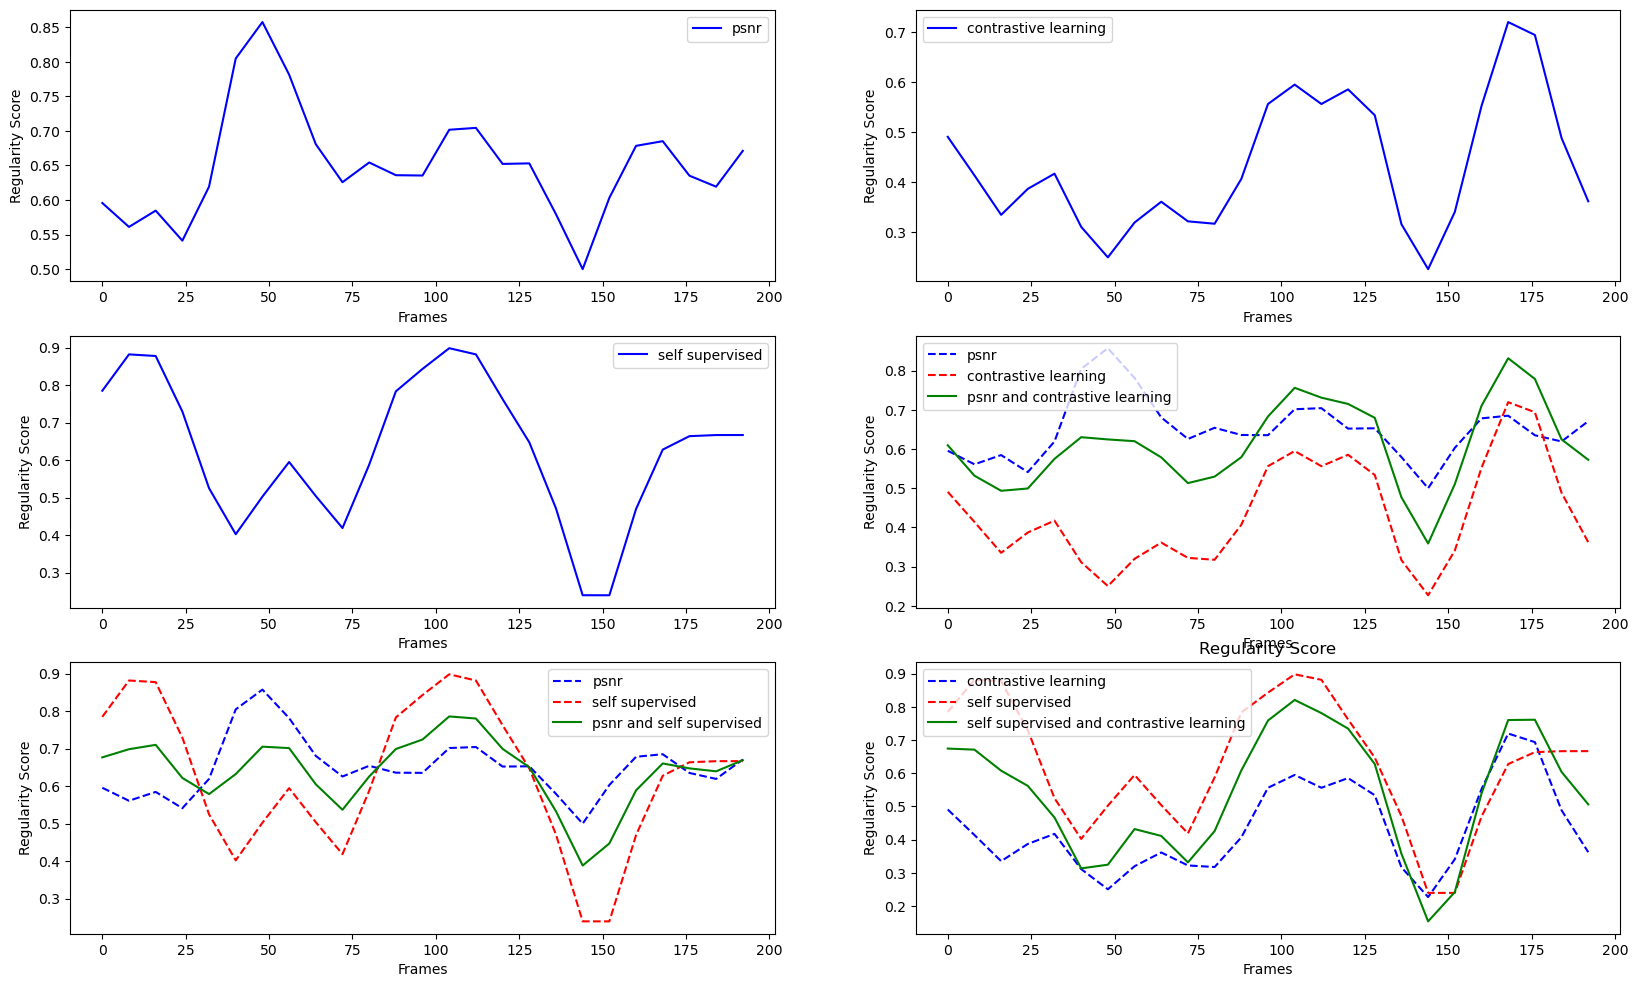

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming 'regularity_score' is your input tensor
# score = regularity_score.cpu().detach().numpy()

# Create x values for the plot (multiplying by 8 as required)
x = [i * 8 for i in range(len(final_scores1))]

# Apply Gaussian filter for smoothing (sigma controls the level of smoothing)
smoothed_score = gaussian_filter1d(final_scores1, sigma=1)
smoothed_score2 = gaussian_filter1d(final_scores2, sigma=1)
smoothed_score3=gaussian_filter1d(final_scores3, sigma=1)
smoothed_score4 = gaussian_filter1d(final_scores4, sigma=1)
smoothed_score5 = gaussian_filter1d(final_scores5, sigma=1)
smoothed_score6=gaussian_filter1d(final_scores6, sigma=1)

# Plot original and smoothed score
plt.figure(figsize=(20,12))
plt.subplot(3,2,1)
plt.plot(x, smoothed_score, label='psnr', color='blue')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.subplot(3,2,2)
plt.plot(x, smoothed_score2, label='contrastive learning', color='blue')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.subplot(3,2,3)
plt.plot(x, smoothed_score3, label='self supervised', color='blue')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.subplot(3,2,4)
plt.plot(x, smoothed_score, label='psnr', color='blue', linestyle='--')
plt.plot(x, smoothed_score2, label='contrastive learning', color='red', linestyle='--')
plt.plot(x, smoothed_score4, label='psnr and contrastive learning', color='green')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.subplot(3,2,5)
plt.plot(x, smoothed_score, label='psnr', color='blue', linestyle='--')
plt.plot(x, smoothed_score3, label='self supervised', color='red', linestyle='--')
plt.plot(x, smoothed_score5, label='psnr and self supervised', color='green')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.subplot(3,2,6)
plt.plot(x, smoothed_score2, label='contrastive learning', color='blue', linestyle='--')
plt.plot(x, smoothed_score3, label='self supervised', color='red', linestyle='--')
plt.plot(x, smoothed_score6, label='self supervised and contrastive learning', color='green')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.title('Regularity Score')
plt.savefig("overall_score_test_overall.png")
plt.show()

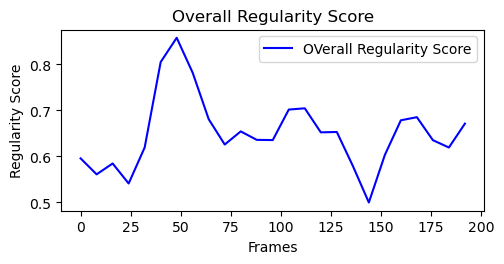

In [31]:
smoothed_score7=gaussian_filter1d(final_scores7, sigma=1)
plt.figure(figsize=(12, 8))
plt.subplot(3,2,1)
plt.plot(x, smoothed_score, label='OVerall Regularity Score', color='blue')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.title('Overall Regularity Score')
plt.show()

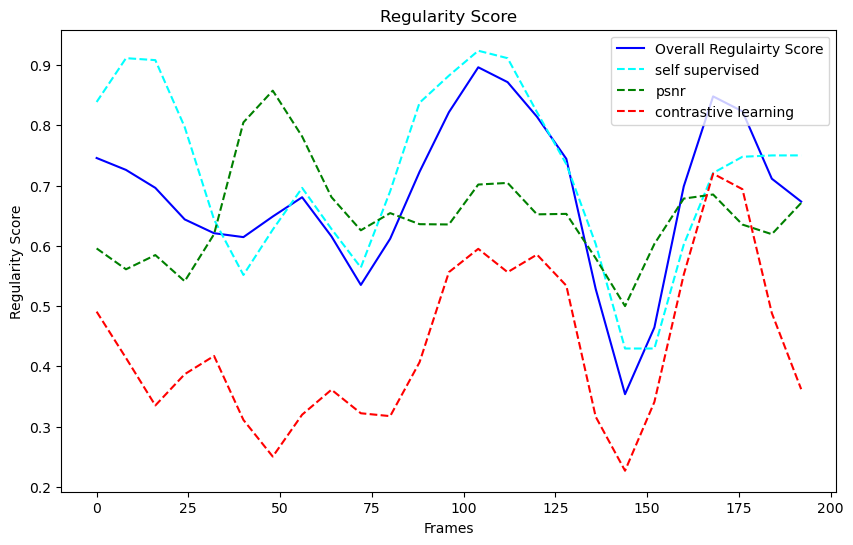

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming 'regularity_score' is your input tensor
# score = regularity_score.cpu().detach().numpy()

# Create x values for the plot (multiplying by 8 as required)
x = [i * 8 for i in range(len(final_scores7))]

# Apply Gaussian filter for smoothing (sigma controls the level of smoothing)
smoothed_score = gaussian_filter1d(final_scores7, sigma=1)
smoothed_score2 = gaussian_filter1d(regularity_scores, sigma=1)
smoothed_score3=gaussian_filter1d(regularity_scores_frame, sigma=1)
smoothed_score4 = gaussian_filter1d(regularity_scores_cl_norm, sigma=1)
# Plot original and smoothed score
plt.figure(figsize=(10, 6))
# plt.plot(x, score, label='Original Score', alpha=0.7)
plt.plot(x, smoothed_score, label='Overall Regulairty Score', linestyle='-', color='blue')
plt.plot(x, smoothed_score2, label='self supervised', linestyle='--', color='cyan')
plt.plot(x, smoothed_score3, label='psnr', linestyle='--', color='green')
plt.plot(x, smoothed_score4, label='contrastive learning', linestyle='--', color='red')
plt.xlabel('Frames')
plt.ylabel('Regularity Score')
plt.legend()
plt.title('Regularity Score')
plt.savefig("overall_score_test_new_final.png")
plt.show()